In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import re
from pathlib import Path

import mplhep as hep
hep.style.use(hep.style.ATLAS)

from utils import read_perf_analyzer_output, plot_backend_compare
from utils import plot_backend, check_inputpath, check_outputpath

# 1 instance on 1 GPU

In [80]:
custom_backend_results_path = "/pscratch/sd/h/hrzhao/Projects/exatrkx-service/evaluate/slurm/good-1gpu-slurm-16730083/1insts_1gpus/perf_analyzer_16730083_1insts_1gpus_sync.csv"
ensemble_backend_results_path = "/pscratch/sd/h/hrzhao/Projects/exatrkx-service/evaluate_ensemble/slurm/good-1gpu-slurm-16748159/ensemble_1insts_1gpus/perf_analyzer_16748159_1insts_1gpus_sync.csv"
var_name = "Inferences/Second"

direct_inference_results = {
    "Concurrency": [1, 2, 4, 8, 10, 16],
    var_name: [44, 57, 63, 65, 64, 64]
}


In [81]:
pd_custom = read_perf_analyzer_output(custom_backend_results_path)
custom_backend_results = {
    "Concurrency": pd_custom["Concurrency"],
    var_name: pd_custom[var_name]
}

pd_ensemble = read_perf_analyzer_output(ensemble_backend_results_path)
ensemble_backend_results = {
    "Concurrency": pd_ensemble["Concurrency"],
    var_name: pd_ensemble[var_name]
}

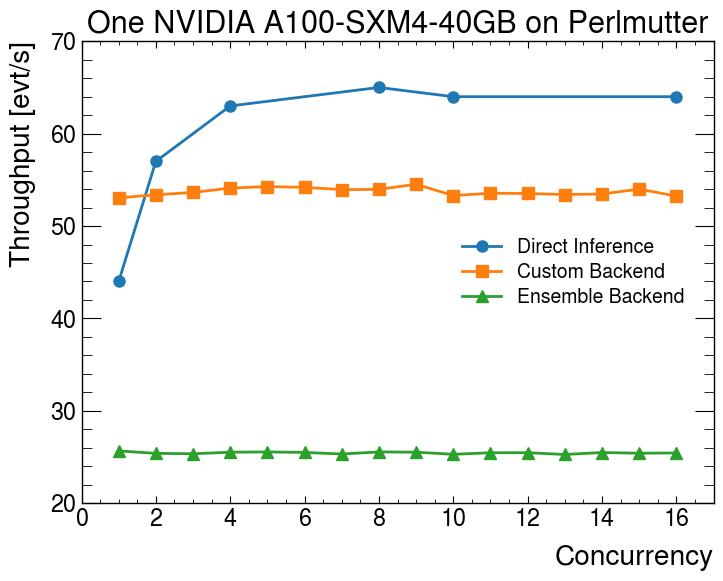

In [86]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(direct_inference_results["Concurrency"], direct_inference_results[var_name], label="Direct Inference", marker="o")
ax.plot(custom_backend_results["Concurrency"], custom_backend_results[var_name], label="Custom Backend", marker="s")
ax.plot(ensemble_backend_results["Concurrency"], ensemble_backend_results[var_name], label="Ensemble Backend", marker="^")

ax.set_xlim(0, 17)
ax.set_xlabel("Concurrency")
ax.set_ylabel("Throughput [evt/s]")
ax.set_title("One NVIDIA A100-SXM4-40GB on Perlmutter", fontsize=22)

ax.legend()
fig.savefig("throughput_vs_concurrency_1inst_1gpu.pdf", dpi=600, bbox_inches="tight")


# Max Throughput vs Instances 

In [88]:
custom_backend_results_path = "/pscratch/sd/h/hrzhao/Projects/exatrkx-service/evaluate/slurm/good-1gpu-slurm-16730083/"
ensemble_backend_results_path = "/pscratch/sd/h/hrzhao/Projects/exatrkx-service/evaluate_ensemble/slurm/good-1gpu-slurm-16748159/"
custom_backend_results_path = check_inputpath(custom_backend_results_path)
ensemble_backend_results_path = check_inputpath(ensemble_backend_results_path)

pattern = r'(\d+)insts'
sync_mode = "sync"
n_instance_threshold = 6

def extract_number_GPUutilization(s):
    match = re.search(r'(\d+\.\d+)', s)
    if match:
        return float(match.group(1))
    return None


In [89]:
def exatract_perf_vs_instances(backend_results_path):
    backend_results = {
        "n_instances": [],
        "Throughput_mean": [],
        "Throughput_std": [], 
        "GPU Utilization": [],
    }

    different_ins_results_path = sorted([item for item in backend_results_path.iterdir() if item.is_dir()])
    for instance_result_path in different_ins_results_path:
        
        match = re.search(pattern, instance_result_path.stem)
        if match:
            n_instance = int(match.group(1)) 
        else:
            raise ValueError("No instance number found in the path.") 

        backend_results["n_instances"].append(n_instance)
        csv_file_pattern = f"*_{sync_mode}.csv"
        csv_file = sorted(instance_result_path.glob(csv_file_pattern))[0]

        pd_csv = read_perf_analyzer_output(csv_file)

        pd_saturated = pd_csv.query(f"Concurrency >= {n_instance_threshold}")
        backend_results["Throughput_mean"].append(pd_saturated[var_name].mean())
        backend_results["Throughput_std"].append(pd_saturated[var_name].std())
        
        gpu_util = pd_saturated['Avg GPU Utilization'].apply(extract_number_GPUutilization).mean()
        backend_results["GPU Utilization"].append(gpu_util)

    return backend_results

In [90]:
custom_backend_results = exatract_perf_vs_instances(custom_backend_results_path)

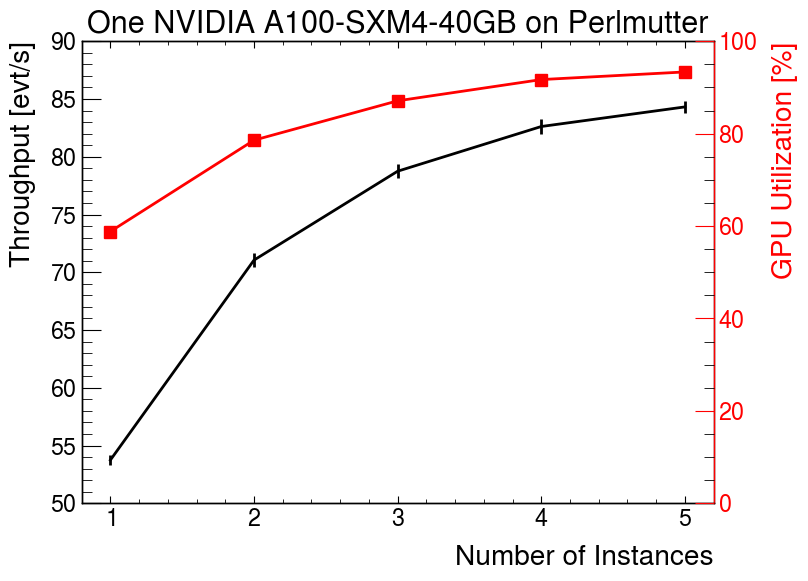

In [91]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xticks(custom_backend_results["n_instances"])
ax.errorbar(custom_backend_results["n_instances"], 
            custom_backend_results["Throughput_mean"], 
            yerr=custom_backend_results["Throughput_std"], 
            label="Custom Backend", color="black")

# twin object for two different y-axis on the sample plot
ax2_color = "red"
ax2=ax.twinx()
ax2.plot(custom_backend_results["n_instances"], 
         np.array(custom_backend_results["GPU Utilization"]) * 100, 
         label="GPU Utilization", color="red", marker="s")

ax2.tick_params(axis='y', colors=ax2_color)
ax2.spines['right'].set_color(ax2_color)

ax.set_xlabel("Number of Instances")
ax.set_ylabel("Throughput [evt/s]")
ax.set_title("One NVIDIA A100-SXM4-40GB on Perlmutter", fontsize=22)

ax2.set_ylim(0,100)
ax2.set_ylabel("GPU Utilization [%]", color=ax2_color)

ax.set_xlim(0.8, 5.2)

fig.savefig("avg_throughput_vs_instances_1gpu.pdf", dpi=600, bbox_inches="tight")

In [50]:
custom_backend_results = {
    "n_instances": [],
    "Throughput_mean": [],
    "Throughput_std": [], 
    "GPU Utilization": [],
}

different_ins_results_path = sorted([item for item in custom_backend_results_path.iterdir() if item.is_dir()])
for instance_result_path in different_ins_results_path:
    
    match = re.search(pattern, instance_result_path.stem)
    if match:
        n_instance = int(match.group(1)) 
    else:
        raise ValueError("No instance number found in the path.") 

    custom_backend_results["n_instances"].append(n_instance)
    csv_file_pattern = f"*_{sync_mode}.csv"
    csv_file = sorted(instance_result_path.glob(csv_file_pattern))[0]

    pd_csv = read_perf_analyzer_output(csv_file)

    print(csv_file.stem)
    # custom_backend_results["Thourghput"].append(pd_csv[var_name].max())

    pd_saturated = pd_csv.query(f"Concurrency >= {n_instance_threshold}")
    custom_backend_results["Throughput_mean"].append(pd_saturated[var_name].mean())
    custom_backend_results["Throughput_std"].append(pd_saturated[var_name].std())
    
    gpu_util = pd_saturated['Avg GPU Utilization'].apply(extract_number_GPUutilization).mean()
    custom_backend_results["GPU Utilization"].append(gpu_util)

    


perf_analyzer_16730083_1insts_1gpus_sync
perf_analyzer_16730083_2insts_1gpus_sync
perf_analyzer_16730083_3insts_1gpus_sync
perf_analyzer_16730083_4insts_1gpus_sync
perf_analyzer_16730083_5insts_1gpus_sync


In [51]:
custom_backend_results

{'n_instances': [1, 2, 3, 4, 5],
 'Throughput_mean': [53.73859090909091,
  71.05103636363637,
  78.74718181818183,
  82.61845454545455,
  84.31504545454547],
 'Throughput_std': [0.4093027448101112,
  0.5870858357561132,
  0.5854194493150733,
  0.6520013609857508,
  0.4912120221729835],
 'GPU Utilization': [0.5881695454545454,
  0.7858334545454546,
  0.8710606363636363,
  0.9170456363636365,
  0.9335736363636363]}

In [39]:
pd_saturated = pd_csv.query("Concurrency >= 6")

ValueError: could not convert string to float: '0.592778;'

In [41]:
pd_saturated['Avg GPU Utilization']

13    GPU-2af694c9-cce3-f946-8466-da0c9451132e:0.592...
9        GPU-2af694c9-cce3-f946-8466-da0c9451132e:0.59;
10    GPU-2af694c9-cce3-f946-8466-da0c9451132e:0.590...
15    GPU-2af694c9-cce3-f946-8466-da0c9451132e:0.592...
2     GPU-2af694c9-cce3-f946-8466-da0c9451132e:0.582...
7     GPU-2af694c9-cce3-f946-8466-da0c9451132e:0.582...
6     GPU-2af694c9-cce3-f946-8466-da0c9451132e:0.589...
4     GPU-2af694c9-cce3-f946-8466-da0c9451132e:0.595...
5      GPU-2af694c9-cce3-f946-8466-da0c9451132e:0.5825;
11    GPU-2af694c9-cce3-f946-8466-da0c9451132e:0.596...
1     GPU-2af694c9-cce3-f946-8466-da0c9451132e:0.575...
Name: Avg GPU Utilization, dtype: object

In [38]:
pd_csv.query("Concurrency >= 6")[var_name].std()

0.4093027448101112

In [25]:
different_ins_results_path

[PosixPath('/pscratch/sd/h/hrzhao/Projects/exatrkx-service/evaluate/slurm/good-1gpu-slurm-16730083/1insts_1gpus'),
 PosixPath('/pscratch/sd/h/hrzhao/Projects/exatrkx-service/evaluate/slurm/good-1gpu-slurm-16730083/2insts_1gpus'),
 PosixPath('/pscratch/sd/h/hrzhao/Projects/exatrkx-service/evaluate/slurm/good-1gpu-slurm-16730083/3insts_1gpus'),
 PosixPath('/pscratch/sd/h/hrzhao/Projects/exatrkx-service/evaluate/slurm/good-1gpu-slurm-16730083/4insts_1gpus'),
 PosixPath('/pscratch/sd/h/hrzhao/Projects/exatrkx-service/evaluate/slurm/good-1gpu-slurm-16730083/5insts_1gpus')]

In [29]:
import re

s = "ensemble_2insts_1gpus"


if match:
    print(match.group(1))

2


In [ ]:
different_ins_results_path = sorted([item for item in custom_backend_results_path.iterdir() if item.is_dir()])


In [ ]:
custom_backend_results = "/pscratch/sd/h/hrzhao/Projects/exatrkx-service/evaluate/slurm/good-1gpu-slurm-16730083"
ensemble_backend_results = "/pscratch/sd/h/hrzhao/Projects/exatrkx-service/evaluate_ensemble/slurm/good-1gpu-slurm-16748159"
var_name = "Inferences/Second"

custom_backend_results = check_inputpath(custom_backend_results)
ensemble_backend_results = check_inputpath(ensemble_backend_results)

different_ins_results_path = sorted([item for item in custom_backend_results.iterdir() if item.is_dir()])

sync_modes = ["async", "sync"]
n_gpus_label = different_ins_results_path[0].stem.split("_")[1]

for sync_mode in sync_modes:
    
    for instance_result_path in different_ins_results_path:
        if instance_result_path.stem.startswith("bad"):
            continue
        custom_instance_result_path = instance_result_path 
        ensemble_instance_result_path = ensemble_backend_results / f"ensemble_{instance_result_path.stem}"
        ensemble_instance_result_path = check_inputpath(ensemble_instance_result_path)

        instance_label = instance_result_path.stem
        instance_label = "_".join(instance_label.split('_')[-2:])
        csv_file_pattern = f"*{instance_label}_{sync_mode}.csv"
        custom_csv_file = sorted(instance_result_path.glob(csv_file_pattern))
        ensemble_csv_file = sorted(ensemble_instance_result_path.glob(csv_file_pattern))

        custom_df_csv = read_perf_analyzer_output(custom_csv_file[0])
        ensemble_df_csv = read_perf_analyzer_output(ensemble_csv_file[0])

        fig, ax = plt.subplots()
        ax.plot(custom_df_csv['Concurrency'], custom_df_csv[var_name], marker = "o", label = "custom backend")
        ax.plot(ensemble_df_csv['Concurrency'], ensemble_df_csv[var_name], marker = "^", label="ensemble scheduler")

        ax.set_xlabel("Concurrency")
        ax.set_ylabel(var_name)
        ax.set_title(f"{var_name} vs Concurrency, {instance_label}, {sync_mode} mode")

        ax.legend()
    